# Model Monitoring for Cardiac Image Segmentation

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-a8c819b9-a437-a7f9-fd35-a738e68f29e5)


In [2]:
import random
import numpy as np
import torch

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Install requirements

#### batchgenerators

In [3]:
!pip install --upgrade batchgenerators

     |████████████████████████████████| 57 kB 2.2 MB/s 
     |████████████████████████████████| 96 kB 3.3 MB/s 
  Created wheel for batchgenerators: filename=batchgenerators-0.23-py3-none-any.whl size=84780 sha256=1d390b8ab1228ce0a3fca4c194d5083c7215a62177a3dc0e8e94994f69c62266
  Stored in directory: /root/.cache/pip/wheels/81/3d/a2/9a602ce56458c684d2962ec89eddd6bc06b00687735e2dd11a
Successfully built batchgenerators


#### medpy

In [4]:
!pip install medpy

     |████████████████████████████████| 151 kB 2.6 MB/s 
     |████████████████████████████████| 48.4 MB 9.3 kB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754469 sha256=b9f9e84586c953ff565f5b32a79925bdec034d2d9430c87f2b4f8b82b2ae0756
  Stored in directory: /root/.cache/pip/wheels/b0/57/3a/da1183f22a6afb42e11138daa6a759de233fd977a984333602
Successfully built medpy


#### nibabel

In [5]:
!pip install nibabel

## Import data

In [6]:
!git clone https://github.com/manigalati/quality_control_CMR

Cloning into 'quality_control_CMR'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 141 (delta 80), reused 4 (delta 3), pack-reused 0
Receiving objects: 100% (141/141), 476.03 KiB | 10.58 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [7]:
%cd /content/quality_control_CMR

/content/quality_control_CMR


In [8]:
!mkdir data
#training set
!python gdrivedl.py https://drive.google.com/open?id=1bxRj0zf-iMooYA4jUZS_zS4VD9NLYxE4 data/
#testing set
!python gdrivedl.py https://drive.google.com/open?id=1L84oEmgc2Nd10bCBlaM7vkbl7nhrYC9I data/
#predictions
!python gdrivedl.py https://drive.google.com/open?id=1P2kNGllKUKmumaCM2IsqgIgRPAKEXa59 data/
#measures
!python gdrivedl.py https://drive.google.com/open?id=1ss-qGFEocJT-h3JAebcDjeWBQXcxPs0T data/

data/training.zip
[==================================================] 1554.02MB/1554.02MB
data/testing.zip
[==================================================] 762.27MB/762.27MB
data/predictions.zip
[==================================================] 3.75MB/3.75MB
data/measures.zip
[==================================================] 0.05MB/0.05MB


In [9]:
!unzip -q data/training.zip -d data/

In [10]:
!unzip -q data/testing.zip -d data/ 
!mv data/testing/testing data/tmp && rm -r data/testing && mv data/tmp data/testing

In [11]:
!unzip -q data/predictions.zip -d data/

In [12]:
!unzip -q data/measures.zip -d data/

## Data preparation

In [13]:
import os
import numpy as np
from utils import generate_patient_info, preprocess

In [14]:
patient_info = generate_patient_info("data/training/", patient_ids=range(1, 101))
patient_info = {**patient_info, **generate_patient_info("data/testing/", patient_ids=range(101, 151))}

if not os.path.exists("preprocessed/"):
    os.makedirs("preprocessed/")
np.save(os.path.join("preprocessed/", "patient_info"), patient_info)

In [15]:
#spacings = [patient_info[id]["spacing"] for id in range(1, 101)]
#spacing_target = np.percentile(np.vstack(spacings), 50, 0)
spacing_target = [10, 1.25, 1.25]

if not os.path.exists("preprocessed/training/"):
    os.makedirs("preprocessed/training/")
preprocess(
    range(1,101), patient_info, spacing_target,
    "data/training", "preprocessed/training",
    lambda folder, id: os.path.join(folder, 'patient{:03d}'.format(id)),
    lambda patient_info, id, phase: "patient{:03d}_frame{:02d}_gt.nii.gz".format(id, patient_info[id][phase])
)

In [16]:
for model in os.listdir("data/predictions/"):
    if not os.path.exists("preprocessed/predictions/{}".format(model)):
        os.makedirs("preprocessed/predictions/{}".format(model))
    preprocess(
        range(101,151), patient_info, spacing_target,
        "data/predictions/{}".format(model), "preprocessed/predictions/{}".format(model),
        lambda folder, id: folder,
        lambda patient_info, id, phase: "patient{:03d}_{}.nii.gz".format(id,phase)
    )

## Dataset

In [17]:
import os
import numpy as np
import random
import torchvision
from utils import AddPadding, CenterCrop, OneHot, ToTensor, MirrorTransform, SpatialTransform

In [18]:
ids = random.sample(range(1, 101), 100)
train_ids = ids[:80]
val_ids = ids[80:]

transform = torchvision.transforms.Compose([
    AddPadding((256,256)),
    CenterCrop((256,256)),
    OneHot(),
    ToTensor()
])
transform_augmentation = torchvision.transforms.Compose([
    MirrorTransform(),
    SpatialTransform(patch_size=(256,256), angle_x=(-np.pi/6,np.pi/6), scale=(0.7,1.4), random_crop=True),
    OneHot(),
    ToTensor()
])

## Training

In [19]:
import torch

from CA import AE, plot_history, hyperparameter_tuning
from utils import ACDCDataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
#the following cell allows the user to tune his own hyperparameters. In case you wanna try our hyperparameters first, just skip this cell.

#this is a list of possible values being tested for each hyperparameter.
parameters = {
    "DA": [True, False], #data augmentation
    "latent_size": [100, 500], #size of the latent space of the autoencoder
    "BATCH_SIZE": [8, 16, 4],
    "optimizer": [torch.optim.Adam],
    "lr": [2e-4, 1e-4, 1e-3],
    "weight_decay": [1e-5],
    "tuning_epochs": [5, 10], #number of epochs each configuration is run for
    "functions": [["GDLoss", "MSELoss"], ["GDLoss"], ["BKGDLoss", "BKMSELoss"]], #list of loss functions to be evaluated. BK stands for "background", which is a predominant and not compulsory class (it can lead to a dumb local minimum retrieving totally black images).
    "settling_epochs_BKGDLoss": [10, 0], #during these epochs BK has half the weight of LV, RV and MYO in the evaluation of BKGDLoss
    "settling_epochs_BKMSELoss": [10, 0], #during these epochs BK has half the weight of LV, RV and MYO in the evaluation of BKMSELoss
}

#this is a list of rules cutting out some useless combinations of hyperparameters from the tuning process.
rules = [
    '"settling_epochs_BKGDLoss" == 0 or "BKGDLoss" in "functions"',
    '"settling_epochs_BKMSELoss" == 0 or "BKMSELoss" in "functions"',
    '"BKGDLoss" not in "functions" or "settling_epochs_BKGDLoss" <= "tuning_epochs"',
    '"BKMSELoss" not in "functions" or "settling_epochs_BKMSELoss" <= "tuning_epochs"',
    #'"BKGDLoss" not in "functions" or "settling_epochs_BKGDLoss" >= "settling_epochs_BKMSELoss"'
]

optimal_parameters = hyperparameter_tuning(
    parameters,
    ACDCDataLoader("preprocessed/training", patient_ids=train_ids, batch_size=None, transform=None),
    ACDCDataLoader("preprocessed/training", patient_ids=val_ids, batch_size=None, transform=None),
    transform, transform_augmentation,
    rules,
    fast=True) #very important parameter. When False, all combinations are tested to return the one retrieving the maximum DSC. When True, the first combination avoiding dumb local minima is returned.

np.save(os.path.join("preprocessed/", "optimal_parameters"), optimal_parameters)

{'BATCH_SIZE': 8, 'DA': True, 'latent_size': 100, 'optimizer': <class 'torch.optim.adam.Adam'>, 'lr': 0.0002, 'weight_decay': 1e-05, 'functions': ['GDLoss', 'MSELoss', 'BKMSELoss'], 'settling_epochs': 2, 'tuning_epochs': 5}
Epoch [0]
GDLoss	MSELos	BKMSEL	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
-0.016	0.0150	0.0230	0.0214	0.9762	14.324	0.0000	nan	0.0000	nan	0.0000	nan	
Epoch [1]
GDLoss	MSELos	BKMSEL	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
-0.007	0.0143	0.0213	0.0280	0.9762	14.324	0.0000	nan	0.0000	nan	0.0005	nan	
Epoch [2]
GDLoss	MSELos	BKMSEL	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
-0.174	0.0114	0.0139	-0.149	0.9871	12.592	0.0068	43.099	0.1382	11.928	0.5386	9.5335	
Epoch [3]
GDLoss	MSELos	BKMSEL	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
-0.277	0.0096	0.0114	-0.256	0.9902	11.781	0.0282	46.196	0.2792	10.627	0.6930	10.234	
Epoch [4]
GDLoss	MSELos	BKMSEL	Total	BK_dc	BK_hd	RV_dc	RV_hd	MYO_dc	MYO_hd	LV_dc	LV_hd	
-0.355	0.0085	

AE(
  (encoder): Sequential(
    (0): Conv2d(4, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.5, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Dropout(p=0.5, inplace=False)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2)
    (15): Dropout(p=0.5, inplace=False

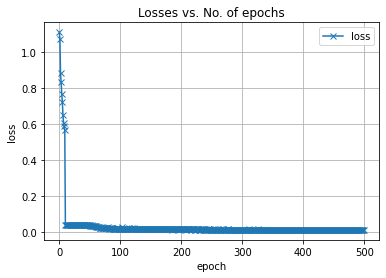

In [21]:
upload_your_own_parameters = True

if upload_your_own_parameters:
    optimal_parameters = np.load(os.path.join("preprocessed", "optimal_parameters.npy"), allow_pickle=True).item()
else:
    optimal_parameters = {
        "BATCH_SIZE": 8,
        "DA": False,
        "latent_size": 100,
        "optimizer": torch.optim.Adam,
        "lr": 2e-4,
        "weight_decay": 1e-5,
        "functions": ["BKGDLoss", "BKMSELoss"],
        "settling_epochs_BKGDLoss": 10,
        "settling_epochs_BKMSELoss": 0
    }

assert optimal_parameters is not None, "Be sure to continue with a working set of hyperparameters"

BATCH_SIZE = optimal_parameters["BATCH_SIZE"]
DA = optimal_parameters["DA"]

ae = AE(**optimal_parameters).to(device)

ckpt = None
if ckpt is not None:
    ckpt = torch.load(ckpt)
    ae.load_state_dict(ckpt["AE"])
    ae.optimizer.load_state_dict(ckpt["AE_optim"])
    start = ckpt["epoch"]+1
else:
    start = 0

print(ae)

plot_history(
    ae.training_routine(
        range(start, 500),
        ACDCDataLoader("preprocessed/training", patient_ids=train_ids, batch_size=BATCH_SIZE, transform=transform_augmentation if DA else transform),
        ACDCDataLoader("preprocessed/training", patient_ids=val_ids, batch_size=BATCH_SIZE, transform=transform),
        "checkpoints/"
    )
)

## Testing

In [22]:
import os
import numpy as np
import torch
import nibabel as nib
from CA import AE
from utils import testing, display_image, display_difference, process_results, display_plots, ACDCDataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
optimal_parameters = np.load(os.path.join("preprocessed", "optimal_parameters.npy"), allow_pickle=True).item()
assert optimal_parameters is not None, "Be sure to continue with a working set of hyperparameters"

ckpt = os.path.join("checkpoints", sorted([file for file in os.listdir("checkpoints") if "_best" in file])[-1])
ckpt = torch.load(ckpt)

ae = AE(**optimal_parameters).to(device)
ae.load_state_dict(ckpt["AE"])
ae.optimizer.load_state_dict(ckpt["AE_optim"])
ae.eval();

In [24]:
patient_info = np.load("preprocessed/patient_info.npy", allow_pickle=True).item()
#spacings = [patient_info[id]["spacing"] for id in range(1, 101)]
#current_spacing = np.percentile(np.vstack(spacings), 50, 0)
current_spacing = [10, 1.25, 1.25]

In [25]:
test_loaders = {}
for model in os.listdir("preprocessed/predictions/"):
    test_loaders[model] = ACDCDataLoader("preprocessed/predictions/{}".format(model), patient_ids=range(101, 151), batch_size=BATCH_SIZE, transform=transform)

if not os.path.exists("postprocessed/measures"):
    os.makedirs("postprocessed/measures")
for model in sorted(test_loaders.keys()):
    if not os.path.exists("postprocessed/predictions/{}".format(model)):
        os.makedirs("postprocessed/predictions/{}".format(model))
    results = testing(ae, test_loaders[model], patient_info, "data/predictions/{}".format(model), "postprocessed/predictions/{}".format(model), current_spacing)
    np.save("postprocessed/measures/{}_AE.npy".format(model), results)

### Single patient

In [26]:
model = "Bai"
patient_id = 102
phase = "ED"

prediction = nib.load("data/predictions/{}/patient{:03d}_{}.nii.gz".format(model, patient_id, phase)).get_fdata().transpose(2, 1, 0)
reconstruction = nib.load("postprocessed/predictions/{}/patient{:03d}_{}.nii.gz".format(model, patient_id, phase)).get_fdata().transpose(2, 1, 0)

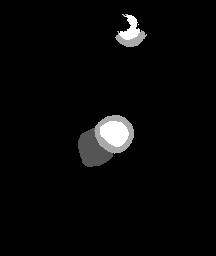

In [27]:
from utils import display_image, display_difference
display_image(prediction[2])

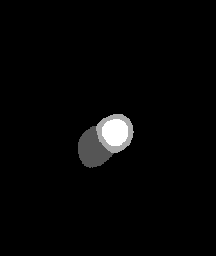

In [28]:
display_image(reconstruction[2])

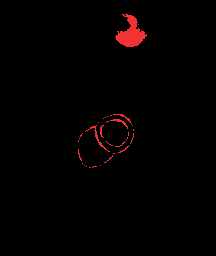

In [29]:
display_difference(prediction[2], reconstruction[2])

### Plots

In [30]:
models = ["Bai", "Baumgartner", "Grinias", "Isensee", "Khened", "Yang"]
plots = process_results(models, "data/measures/", "postprocessed/measures/")

Anomalies (DSC=0/HD=nan): 16
Spotted by CA: 15
False Positive by CA: 4
Total discarded from the next plots: 20


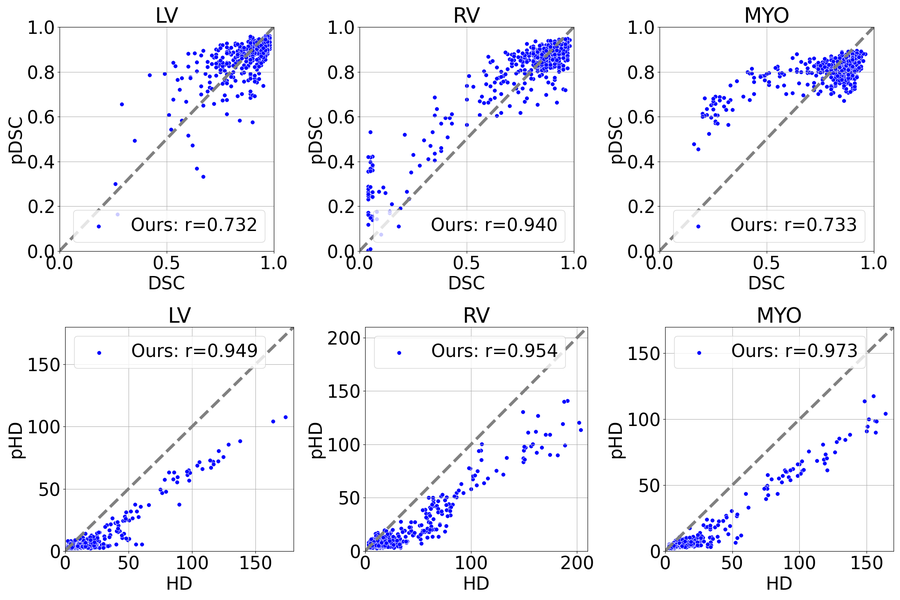

In [31]:
display_plots(plots)